## Implementation of Light GCN Model for Recommendation System from scratch using Pytorch.


* Light GCN was originally Developed By Microsoft and was released in Jul'2020. It is the SOTA Algorithm for Recommendation System as of now.
* Link to the original paper -> https://paperswithcode.com/paper/lightgcn-simplifying-and-powering-graph/review/
* There is also a Github Link to Light GCN implementation using Tensorflow -> https://github.com/microsoft/recommenders/tree/efaa3d7742183dee0846877e2dc64977098e1977
* I have taken help from the above Repository and tried to recreate LightGCN in pytorch.
* In the 2nd part of the notebook, I have also compared my result with the direct result from Original Tensorflow code. 

### Please do upvote the notebook if you liked the content. It will motivate me. Thanks !!

In [1]:
import torch
torch.__version__

'1.9.0+cu111'

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Funciones para la carga de los datos

In [3]:
def load_data_100k(path='./', delimiter='\t'):
    # loading the dataset for Movielens100K
    train = np.loadtxt(path+'movielens_100k_u1.base', skiprows=0, delimiter=delimiter).astype('int32')
    test = np.loadtxt(path+'movielens_100k_u1.test', skiprows=0, delimiter=delimiter).astype('int32')
    total = np.concatenate((train, test), axis=0)
    
    df_train = pd.DataFrame(train, columns = ['user_id','item_id','rating', 'timestamp'])
    df_train = df_train[df_train['rating']>=3] # retornando los ratings mayores a 3
    df_test = pd.DataFrame(test, columns = ['user_id','item_id','rating', 'timestamp'])
    df_test = df_test[df_test['rating']>=3]
    
    print("Rating Distribution Train: ")
    print(df_train.groupby(['rating'])['rating'].count())
    print("Rating Distribution Test: ")
    print(df_test.groupby(['rating'])['rating'].count())
    
    print("\nTrain Size  : ", len(df_train))
    print("Test Size : ", len (df_test))
    return df_train, df_test 

# Cargando los datos

In [4]:
# Inserta el path del directorio de datos por ti mismo (p.ej., '/content/.../data')
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
data_path = 'data'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._

In [5]:
# Seleccionaremos solo el dataset de 'ML-100K'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
dataset = 'ML-100K'
# .-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._

In [6]:
# Data Load
try:
    if dataset == 'ML-100K':
        path = data_path + '/MovieLens_100K/'
        train, test = load_data_100k(path=path, delimiter='\t')
    else:
        raise ValueError

except ValueError:
    print('Error: Unable to load data')

Rating Distribution Train: 
rating
3    21963
4    27396
5    16744
Name: rating, dtype: int64
Rating Distribution Test: 
rating
3    5182
4    6778
5    4457
Name: rating, dtype: int64

Train Size  :  66103
Test Size :  16417


#### Label Encoding the User and Item IDs

In [8]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['item_id_idx'] = le_item.fit_transform(train['item_id'].values)

In [9]:
train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]
print(len(test))

943 1548
16389


In [10]:
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['item_id_idx'] = le_item.transform(test['item_id'].values)

In [13]:
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1548


### latent_dim is the length of the user/item embedding. 
### n_layers is the number of times we want to propagate our initial user/item embedding through the graph 

In [12]:
latent_dim = 64
n_layers_1 = 1 
n_layers_2 = 2
n_layers_3 = 3

In [14]:
def convert_to_sparse_tensor(dok_mtrx):
    
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

## **Metrics**
### Below Function gets the 4 different metrics out of Test Data -> Recall@K, Precision@K, NDCG@K, MAP@K where K is the top K items we would like to recommend to User. 

In [15]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
 
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean() 

##  **LightGCN Model**
### **get_A_tilda** function is used to get A_tilda which will be multiplied with initial user/item embedding (E0) to create embedding at different layers (n_layers = 3) in **propagate_through_layers** function
### **forward** function is used to look up for initial(E0) and final embedding of a user/item

In [16]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)
        
        # Below Code is toconvert the dok_matrix to sparse tensor.
        
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor
    
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [17]:
lightGCN_1 = LightGCN(train, n_users, n_items, n_layers_1, latent_dim)
lightGCN_2 = LightGCN(train, n_users, n_items, n_layers_2, latent_dim)
lightGCN_3 = LightGCN(train, n_users, n_items, n_layers_3, latent_dim)

In [19]:
print("Size of Learnable Embedding (layers 1): ", list(lightGCN_1.parameters())[0].size())
print("Size of Learnable Embedding (layers 2): ", list(lightGCN_2.parameters())[0].size())
print("Size of Learnable Embedding (layers 3): ", list(lightGCN_3.parameters())[0].size())

Size of Learnable Embedding (layers 1):  torch.Size([2491, 64])
Size of Learnable Embedding (layers 2):  torch.Size([2491, 64])
Size of Learnable Embedding (layers 3):  torch.Size([2491, 64])


### **BPR Loss**

In [20]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
        
    return loss, reg_loss

### Data Loader - Samples users and for each user it sample 1 positive item - which User interacted with in Training Data and 1 negative item - with which User have not interacted.

In [21]:
def data_loader(data, batch_size, n_usr, n_itm):  
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id
  
    indices = [x for x in range(n_usr)]
    
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
  
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
  
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [22]:
optimizer_layer_1 = torch.optim.Adam(lightGCN_1.parameters(), lr = 0.005)
optimizer_layer_2 = torch.optim.Adam(lightGCN_2.parameters(), lr = 0.005)
optimizer_layer_3 = torch.optim.Adam(lightGCN_3.parameters(), lr = 0.005)

In [23]:
EPOCHS = 30
BATCH_SIZE = 1024 
DECAY = 0.0001
K = 10

### **Training Loop**

In [34]:
def training_loop(lightGCN, optimizer, EPOCHS=30, BATCH_SIZE=1024, DECAY=0.0001, K=10, layers=1):
    loss_list_epoch = []
    MF_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []
    ndcg_list = []
    map_list = []

    train_time_list = []
    eval_time_list = [] 

    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train)/BATCH_SIZE)

        final_loss_list = []
        MF_loss_list = []
        reg_loss_list = []

        best_ndcg = -1

        train_start_time = time.time()
        lightGCN.train()
        for batch_idx in range(n_batch):

            optimizer.zero_grad()

            users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

            users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

            mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
            reg_loss = DECAY * reg_loss
            final_loss = mf_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            MF_loss_list.append(mf_loss.item())
            reg_loss_list.append(reg_loss.item())


        train_end_time = time.time()
        train_time = train_end_time - train_start_time

        lightGCN.eval()
        with torch.no_grad():

            final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
            test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


        if test_topK_ndcg > best_ndcg:
            best_ndcg = test_topK_ndcg

            torch.save(final_user_Embed, f'final_user_Embed_layers_{layers}.pt')
            torch.save(final_item_Embed, f'final_item_Embed_layers_{layers}.pt')
            torch.save(initial_user_Embed, f'initial_user_Embed_layers_{layers}.pt')
            torch.save(initial_item_Embed, f'initial_item_Embed_layers_{layers}.pt')


        eval_time = time.time() - train_end_time

        loss_list_epoch.append(round(np.mean(final_loss_list),4))
        MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

        recall_list.append(round(test_topK_recall,4))
        precision_list.append(round(test_topK_precision,4))
        ndcg_list.append(round(test_topK_ndcg,4))
        map_list.append(round(test_topK_map,4))

        train_time_list.append(train_time)
        eval_time_list.append(eval_time)
    
    answers = {
        'recall_list': recall_list,
        'precision_list': precision_list,
        'ndcg_list': ndcg_list,
        'map_list': map_list,
        'loss_list_epoch': loss_list_epoch,
        'MF_loss_list_epoch': MF_loss_list_epoch,
        'reg_loss_list_epoch': reg_loss_list_epoch,
        'train_time_list': train_time_list,
        'eval_time_list': eval_time_list 
    }
    
    return answers

In [47]:
%matplotlib inline
def drawing_metrics(metrics, EPOCHS=30, layers=1):
    epoch_list = [(i+1) for i in range(EPOCHS)]
    
    plt.plot(epoch_list, metrics['recall_list'], label='Recall')
    plt.plot(epoch_list, metrics['precision_list'], label='Precision')
    plt.plot(epoch_list, metrics['ndcg_list'], label='NDCG')
    plt.plot(epoch_list, metrics['map_list'], label='MAP')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(f'Model Layers {layers}')
    plt.legend()
    plt.show()
    
    plt.plot(epoch_list, metrics['loss_list_epoch'], label='Total Training Loss')
    plt.plot(epoch_list, metrics['MF_loss_list_epoch'], label='MF Training Loss')
    plt.plot(epoch_list, metrics['reg_loss_list_epoch'], label='Reg Training Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print("Average time taken to train an epoch -> ", round(np.mean(metrics['train_time_list']),2), " seconds")
    print("Average time taken to eval an epoch -> ", round(np.mean(metrics['eval_time_list']),2), " seconds")
    
    print("\n\nLast Epoch's Test Data Recall -> ", metrics['recall_list'][-1])
    print("Last Epoch's Test Data Precision -> ", metrics['precision_list'][-1])
    print("Last Epoch's Test Data NDCG -> ", metrics['ndcg_list'][-1])
    print("Last Epoch's Test Data MAP -> ", metrics['map_list'][-1])

    print("\nLast Epoch's Train Data Loss -> ", metrics['loss_list_epoch'][-1])

#### Training loop for 1 Layer model

In [35]:
metrics_layer_1 = training_loop(lightGCN_1,optimizer_layer_1, EPOCHS, BATCH_SIZE, DECAY, K, layers=1)

  0%|          | 0/30 [00:00<?, ?it/s]

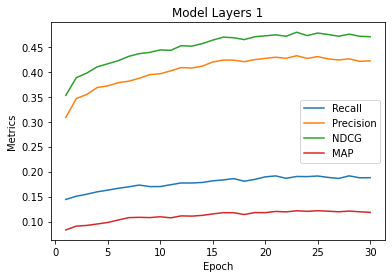

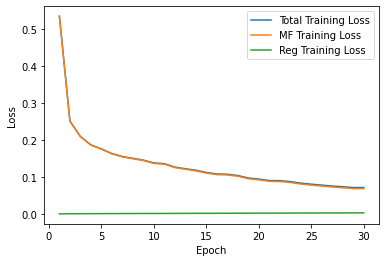

Average time taken to train an epoch ->  3.2  seconds
Average time taken to eval an epoch ->  0.59  seconds


Last Epoch's Test Data Recall ->  0.1878
Last Epoch's Test Data Precision ->  0.4218
Last Epoch's Test Data NDCG ->  0.47
Last Epoch's Test Data MAP ->  0.1184

Last Epoch's Train Data Loss ->  0.0717


In [48]:
drawing_metrics(metrics_layer_1, EPOCHS, n_layers_1)

#### Training loop for 2 Layers model

In [49]:
metrics_layer_2 = training_loop(lightGCN_2,optimizer_layer_2, EPOCHS, BATCH_SIZE, DECAY, K, layers=2)

  0%|          | 0/30 [00:00<?, ?it/s]

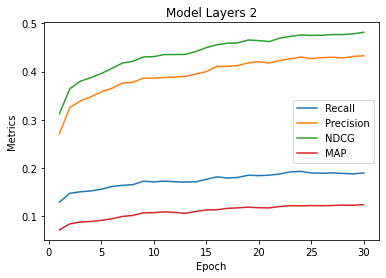

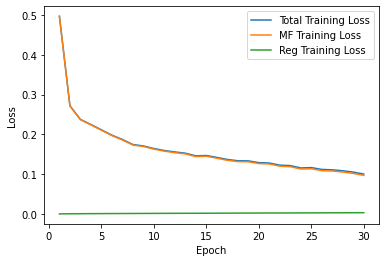

Average time taken to train an epoch ->  5.05  seconds
Average time taken to eval an epoch ->  0.64  seconds


Last Epoch's Test Data Recall ->  0.1894
Last Epoch's Test Data Precision ->  0.4327
Last Epoch's Test Data NDCG ->  0.4816
Last Epoch's Test Data MAP ->  0.1234

Last Epoch's Train Data Loss ->  0.1003


In [50]:
drawing_metrics(metrics_layer_2, EPOCHS, n_layers_2)

#### Training loop for 3 Layers model

In [51]:
metrics_layer_3 = training_loop(lightGCN_3,optimizer_layer_3, EPOCHS, BATCH_SIZE, DECAY, K, layers=3)

  0%|          | 0/30 [00:00<?, ?it/s]

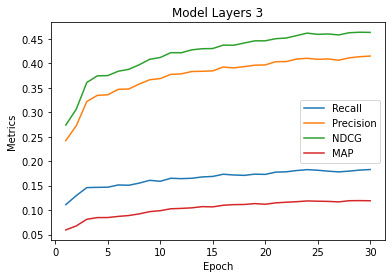

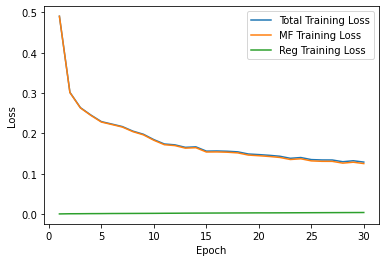

Average time taken to train an epoch ->  5.42  seconds
Average time taken to eval an epoch ->  0.6  seconds


Last Epoch's Test Data Recall ->  0.1828
Last Epoch's Test Data Precision ->  0.4148
Last Epoch's Test Data NDCG ->  0.4632
Last Epoch's Test Data MAP ->  0.119

Last Epoch's Train Data Loss ->  0.1288


In [52]:
drawing_metrics(metrics_layer_3, EPOCHS, n_layers_3)